# Analyze viral escape-mutant selections
Analyze results from viral escape-mutant selections.

Import Python modules:

In [1]:
import collections
import math
import os

import Bio.SeqIO

import dms_variants.constants
from dms_variants.constants import CBPALETTE
from dms_variants.utils import single_nt_accessible

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import mizani

import numpy

import pandas as pd

from plotnine import *

import yaml

Read in configuration and then escape-mutant selection results:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)
    
print(f"Reading escape-mutant selection results from {config['escape_selection_results']}")
with open(config['escape_selection_results']) as f:
    selection_results = yaml.safe_load(f)

Reading escape-mutant selection results from data/escape_selection_results.yaml


Make output directory:

In [3]:
os.makedirs(config['escape_selections_dir'], exist_ok=True)

Read escape-mutation mapping and deep mutational scanning results, and then merge them:

In [4]:
# read escape fractions
escape_fracs = (
    pd.read_csv(config['escape_fracs'])
    .query('library == "average"')
    .rename(columns={config['mut_metric']: 'mutation_escape',
                     config['site_metric']: 'site_escape',
                     'selection': 'antibody'})
    .assign(site=lambda x: x['label_site'])
    [['antibody', 'site', 'wildtype', 'mutation', 'mutation_escape', 'site_escape']]
    )

# read DMS data
bind_expr = (
    pd.read_csv(config['mut_bind_expr'])
    .rename(columns={'site_SARS2': 'site',
                     'bind_avg': 'ACE2 binding',
                     'expr_avg': 'RBD expression',
                     })
    .assign(mutation=lambda x: x['mutant'])
    [['site', 'mutation', 'ACE2 binding', 'RBD expression']]
    )

# merge escape and DMS data
escape_dms = (
    escape_fracs
    .merge(bind_expr,
           on=['site', 'mutation'],
           how='left',
           validate='many_to_one',
           )
    )

# first few lines of data frame
display(HTML(escape_dms.head().to_html(index=False)))

antibody,site,wildtype,mutation,mutation_escape,site_escape,ACE2 binding,RBD expression
CB6_400,331,N,A,0.001044,0.03952,-0.03,-0.11
CB6_400,331,N,D,0.002087,0.03952,0.03,-0.44
CB6_400,331,N,E,0.001044,0.03952,0.00,-0.31
CB6_400,331,N,F,0.001044,0.03952,-0.10,-0.70
CB6_400,331,N,G,0.005013,0.03952,-0.04,-0.25


Get data frame with just escape-selection counts and then add to the main data frame of escape / DMS data:

In [5]:
records = []
antibody_order = {}
spike_nt_seq = {}
for selection_set, selection_set_d in selection_results.items():
    antibody_order[selection_set] = {}
    spike_nt_seq[selection_set] = str(Bio.SeqIO.read(selection_set_d['spike_sequence'],
                                                     'genbank',
                                                     ).seq)
    for antibody, antibody_d in selection_set_d['antibodies'].items():
        antibody_order[selection_set][antibody] = antibody_d['display_name']
        if 'mutations' in antibody_d:
            for mutation_str, n in antibody_d['mutations'].items():
                wt = mutation_str[0]
                site = int(mutation_str[1: -1])
                mutation = mutation_str[-1]
                if ('label_mutations' in antibody_d) and mutation_str in antibody_d['label_mutations']:
                    mutation_label = mutation_str
                else:
                    mutation_label = None
                records.append((selection_set, antibody, site, wt, mutation, n, mutation_label))
                assert 1 == len(escape_dms.query('antibody == @antibody')
                                          .query('wildtype == @wt')
                                          .query('site == @site')
                                          .query('mutation == @mutation')
                                          ), f"{mutation_str} not in `escape_dms` once for {antibody}"
        if 'label_mutations' in antibody_d:
            for mutation_str in antibody_d['label_mutations']:
                if 'mutations' not in antibody_d or mutation_str not in antibody_d['mutations']:
                    wt = mutation_str[0]
                    site = int(mutation_str[1: -1])
                    mutation = mutation_str[-1]
                    records.append((selection_set, antibody, site, wt, mutation, 0, mutation_str))
                    assert 1 == len(escape_dms.query('antibody == @antibody')
                                              .query('wildtype == @wt')
                                              .query('site == @site')
                                              .query('mutation == @mutation')
                                              ), f"{mutation_str} not in `escape_dms` once for {antibody}"
            
selection_df = pd.DataFrame.from_records(
                records,
                columns=['selection_set', 'antibody', 'site',
                         'wildtype', 'mutation', 'n_selected', 'mutation_label'],
                )

display(HTML(selection_df.to_html(index=False)))

selection_set,antibody,site,wildtype,mutation,n_selected,mutation_label
vir_whelan_VSV_main,S2E12_56,476,G,S,1,G476S
vir_whelan_VSV_main,S2E12_56,475,A,D,1,A475D
vir_whelan_VSV_main,S2E12_56,476,G,D,8,G476D
vir_whelan_VSV_main,S2E12_56,485,G,D,6,G485D
vir_whelan_VSV_main,S2D106_68,484,E,A,1,E484A
vir_whelan_VSV_main,S2D106_68,490,F,C,2,F490C
vir_whelan_VSV_main,S2D106_68,484,E,K,11,E484K
vir_whelan_VSV_main,S2D106_68,484,E,V,1,E484V
vir_whelan_VSV_main,S2X58_18,346,R,G,2,R346G
vir_whelan_VSV_main,S2X58_18,484,E,G,1,E484G


Add escape-selection counts and labels to main data frame with escape scores, and just keep antibodies of interest for each selection:

In [6]:
escape_dms_selection = (
    pd.concat([escape_dms.merge(df,
                                on=['antibody', 'site', 'wildtype', 'mutation'],
                                how='left',
                                validate='one_to_one',
                                )
                          .assign(selection_set=selection_set,
                                  antibody_name=lambda x: x['antibody'].map(antibody_order[selection_set])
                                  )
                          .query('antibody_name.notnull()')
               for selection_set, df in selection_df.groupby('selection_set')
               ])
    .assign(n_selected=lambda x: x['n_selected'].fillna(0).astype(int),
            n_selected_total=lambda x: x.groupby(['selection_set', 'antibody'])
                                        ['n_selected'].transform('sum'),
            any_selected=lambda x: x['n_selected'] > 0,
            max_at_site_escape=lambda x: x.groupby(['antibody', 'site'])['mutation_escape'].transform('max'),
            mean_at_site_escape=lambda x: x.groupby(['antibody', 'site'])['mutation_escape'].transform('mean'),
            )
    )

display(HTML(escape_dms_selection.head().to_html(index=False)))

antibody,site,wildtype,mutation,mutation_escape,site_escape,ACE2 binding,RBD expression,selection_set,n_selected,mutation_label,antibody_name,n_selected_total,any_selected,max_at_site_escape,mean_at_site_escape
S2X259_59,331,N,A,0.000922,0.01842,-0.03,-0.11,vir_whelan_VSV_S2X259,0,NaN,S2X259,18,False,0.003219,0.001151
S2X259_59,331,N,D,0.000000,0.01842,0.03,-0.44,vir_whelan_VSV_S2X259,0,NaN,S2X259,18,False,0.003219,0.001151
S2X259_59,331,N,E,0.000608,0.01842,0.00,-0.31,vir_whelan_VSV_S2X259,0,NaN,S2X259,18,False,0.003219,0.001151
S2X259_59,331,N,F,0.003219,0.01842,-0.10,-0.70,vir_whelan_VSV_S2X259,0,NaN,S2X259,18,False,0.003219,0.001151
S2X259_59,331,N,G,0.001120,0.01842,-0.04,-0.25,vir_whelan_VSV_S2X259,0,NaN,S2X259,18,False,0.003219,0.001151


Now add in the viral codon sequence and determine what amino-acid mutations are single-nucleotide accessible:

In [7]:
codon_df = pd.DataFrame()
sites = escape_dms_selection['site'].unique()
for selection_set, spike in spike_nt_seq.items():
    codon_df = codon_df.append(
        pd.DataFrame({'selection_set': selection_set, 'site': sites})
          .assign(viral_codon=lambda x: x['site'].map(lambda r: spike[3 * (r - 1): 3 * r]),
                  viral_aa=lambda x: x['viral_codon'].map(dms_variants.constants.CODON_TO_AA))
        )
    
escape_dms_selection = (
    escape_dms_selection
    .drop(columns=['viral_codon', 'viral_aa'], errors='ignore')
    .merge(codon_df,
           how='left',
           on=['selection_set', 'site'],
           validate='many_to_one',
           )
    .assign(single_nt_accessible=lambda x: x.apply(lambda row: single_nt_accessible(row['viral_codon'],
                                                                                    row['mutation']),
                                                   axis=1)
            )
    )

# check viral spike is same one used in our DMS. If not, we need to somehow deal with that...
aa_mismatch = escape_dms_selection.query('wildtype != viral_aa')
if len(aa_mismatch):
    raise ValueError('mismatches at the following amino acids: ' + aa_mismatch)

display(HTML(escape_dms_selection.head().to_html(index=False)))

antibody,site,wildtype,mutation,mutation_escape,site_escape,ACE2 binding,RBD expression,selection_set,n_selected,mutation_label,antibody_name,n_selected_total,any_selected,max_at_site_escape,mean_at_site_escape,viral_codon,viral_aa,single_nt_accessible
S2X259_59,331,N,A,0.000922,0.01842,-0.03,-0.11,vir_whelan_VSV_S2X259,0,NaN,S2X259,18,False,0.003219,0.001151,AAT,N,False
S2X259_59,331,N,D,0.000000,0.01842,0.03,-0.44,vir_whelan_VSV_S2X259,0,NaN,S2X259,18,False,0.003219,0.001151,AAT,N,True
S2X259_59,331,N,E,0.000608,0.01842,0.00,-0.31,vir_whelan_VSV_S2X259,0,NaN,S2X259,18,False,0.003219,0.001151,AAT,N,False
S2X259_59,331,N,F,0.003219,0.01842,-0.10,-0.70,vir_whelan_VSV_S2X259,0,NaN,S2X259,18,False,0.003219,0.001151,AAT,N,False
S2X259_59,331,N,G,0.001120,0.01842,-0.04,-0.25,vir_whelan_VSV_S2X259,0,NaN,S2X259,18,False,0.003219,0.001151,AAT,N,False


Make plots showing effects of all mutations stratified by how many times observed in selections, and whether single-nucleotide accessible or not from the viral spike.
For mutations observed in selections point size, is proportional to times observed:


Making plot for vir_whelan_VSV_S2X259
Saving plot to results/escape_selections/vir_whelan_VSV_S2X259.pdf and results/escape_selections/vir_whelan_VSV_S2X259.svg


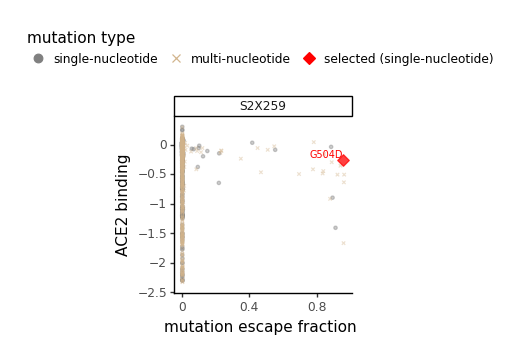


Making plot for vir_whelan_VSV_main


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/guides/guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.


Saving plot to results/escape_selections/vir_whelan_VSV_main.pdf and results/escape_selections/vir_whelan_VSV_main.svg


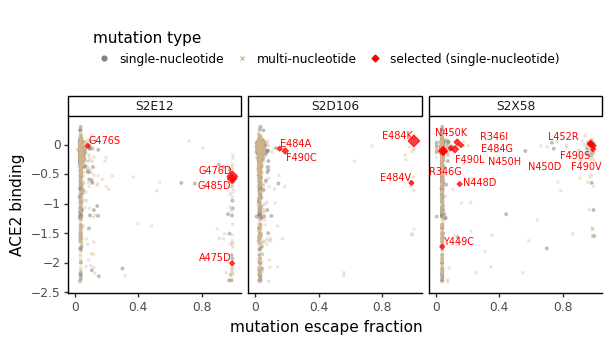


Making plot for vir_whelan_VSV_max_at_site_escape
Saving plot to results/escape_selections/vir_whelan_VSV_max_at_site_escape.pdf and results/escape_selections/vir_whelan_VSV_max_at_site_escape.svg


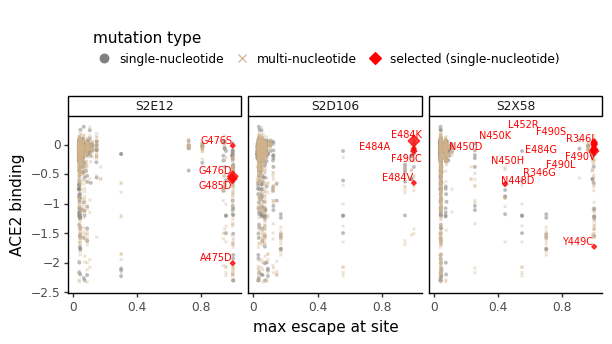


Making plot for vir_whelan_VSV_mean_at_site_escape


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/guides/guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.


Saving plot to results/escape_selections/vir_whelan_VSV_mean_at_site_escape.pdf and results/escape_selections/vir_whelan_VSV_mean_at_site_escape.svg


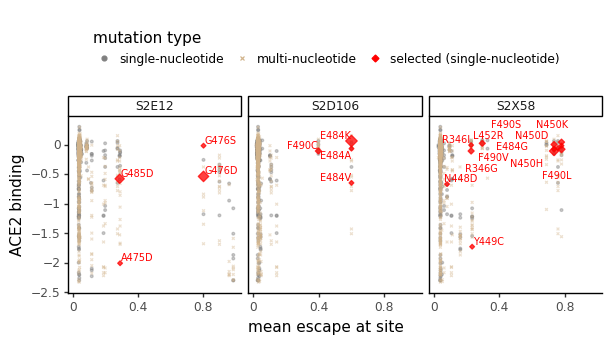


Making plot for vir_whelan_VSV_site_escape
Saving plot to results/escape_selections/vir_whelan_VSV_site_escape.pdf and results/escape_selections/vir_whelan_VSV_site_escape.svg


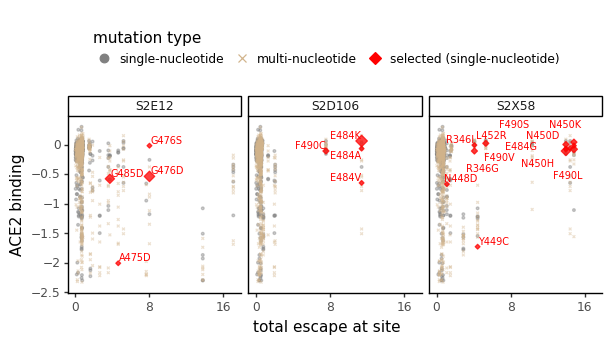


Making plot for vir_whelan_VSV_supp


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/guides/guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.


Saving plot to results/escape_selections/vir_whelan_VSV_supp.pdf and results/escape_selections/vir_whelan_VSV_supp.svg


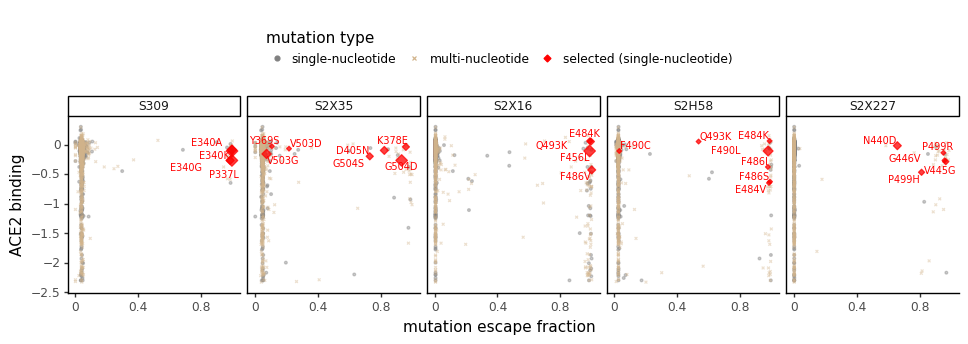

In [8]:
for selection_set, df in escape_dms_selection.groupby('selection_set'):
    
    min_size = selection_results[selection_set]['min_size']
    max_size = selection_results[selection_set]['max_size']
    size_scale = selection_results[selection_set]['max_size']
                                                  
    if 'escape_metric' in selection_results[selection_set]:
        escape_metric = selection_results[selection_set]['escape_metric']
    else:
        escape_metric = 'mutation_escape'
    assert escape_metric in df.columns
                                                  
    if 'ncol' in selection_results[selection_set]:
        ncol = min(df['antibody'].nunique(), selection_results[selection_set]['ncol'])
    else:
        ncol = df['antibody'].nunique()
    nrow = math.ceil(df['antibody'].nunique() / ncol)
    
    print(f"\nMaking plot for {selection_set}")
    
    selected_not_accessible = len(df.query('any_selected and not single_nt_accessible'))
    
    if 'custom_categories' in selection_results[selection_set]:
        custom_cats = selection_results[selection_set]['custom_categories']
        addtl_cats = list({cat: True for a_cats in custom_cats.values() for cat in a_cats.values()})
    else:
        custom_cats = {}
        addtl_cats = []
    
    def get_point_category(row):
        if row['antibody_name'] in custom_cats and (row['mutation_str'] in 
                                                    custom_cats[row['antibody_name']]):
            return custom_cats[row['antibody_name']][row['mutation_str']]
        elif row['any_selected'] and row['single_nt_accessible']:
            return 'selected (single-nucleotide)'
        elif row['any_selected']:
            return 'selected (multi-nucleotide)'
        elif row['single_nt_accessible']:
            return 'single-nucleotide'
        else:
            return 'multi-nucleotide'
        
    df = df.assign(
            mutation_str=lambda x: x['wildtype'] + x['site'].astype(str) + x['mutation'],
            antibody_name=lambda x: pd.Categorical(x['antibody_name'],
                                                   antibody_order[selection_set].values(),
                                                   ordered=True),
            point_area=lambda x: 0.5 * size_scale * numpy.clip(x['n_selected'].fillna(0),
                                                               min_size,
                                                               max_size),
            point_category=lambda x: x.apply(get_point_category, axis=1),
            )
    possible_point_categories = ['single-nucleotide', 'multi-nucleotide',
                                 'selected (single-nucleotide)',
                                 'selected (multi-nucleotide)'] + addtl_cats
    observed_point_categories = [cat for cat in possible_point_categories
                                 if cat in df['point_category'].unique()]
    df = df.assign(point_category=lambda x: pd.Categorical(x['point_category'],
                                                           observed_point_categories,
                                                           ordered=True)
                   )
    
    if 'shapes' in selection_results[selection_set]:
        cat_shapes = selection_results[selection_set]['shapes']
    else:
        cat_shapes = ['o', 'x', 'D', '^']
    assert len(cat_shapes) >= len(observed_point_categories), 'not enough shapes'
    if 'colors' in selection_results[selection_set]:
        cat_colors = selection_results[selection_set]['colors']
    else: 
        cat_colors = [CBPALETTE[2], CBPALETTE[0], CBPALETTE[1], CBPALETTE[1]]
    assert len(cat_colors) >= len(observed_point_categories), 'not enough colors'
    if 'alphas' in selection_results[selection_set]:
        cat_alphas = selection_results[selection_set]['alphas']
    else:  
        cat_alphas = [0.4, 0.3, 0.95, 0.95]
    assert len(cat_colors) >= len(observed_point_categories), 'not enough alphas'
    
    p = (ggplot(df) +
         aes(escape_metric, 'ACE2 binding',
             color='point_category', alpha='point_category',
             size='point_area', shape='point_category', label='mutation_label') +
         geom_point() +
         geom_text(data=df.query('mutation_label.notnull()'),
                   size=(selection_results[selection_set]['label_fontsize'] if
                         'label_fontsize' in selection_results[selection_set]
                         else 8),
                   va='top', ha='right', alpha=1, nudge_x=-0.025, nudge_y=-0.025,
                   show_legend=False,
                   # see here for adjust_text: https://stackoverflow.com/a/57717833
                   adjust_text={'avoid_text': True,
                                'avoid_points': False,
                                'avoid_self': True,
                                'expand_text': [1.05, 1.2]},
                   ) +
         facet_wrap('~ antibody_name',
                    scales=(selection_results[selection_set]['facet_scales']
                            if 'facet_scales' in selection_results[selection_set]
                            else 'fixed'),
                    ncol=ncol) +
         scale_color_manual(values=cat_colors) +
         scale_alpha_manual(values=cat_alphas) +
         scale_size_area(limits=(size_scale * min_size, size_scale * max_size),
                                 max_size=4) +
         scale_shape_manual(values=cat_shapes) +
         theme_classic() +
         scale_x_continuous(name={'mutation_escape': 'mutation escape fraction',
                                  'site_escape': 'total escape at site',
                                  'max_at_site_escape': 'max escape at site',
                                  'mean_at_site_escape': 'mean escape at site',
                                  }[escape_metric],
                            breaks=mizani.breaks.mpl_breaks(nbins=3),
                            
                            ) +
         scale_y_continuous(expand=(0.07, 0)) +
         guides(alpha=False, size=False,
                shape=guide_legend(override_aes={'size': 3},
                                   title='mutation type'),
                color=guide_legend(title='mutation type'),
                ) +
         theme(figure_size=(2.3 * ncol, 2.3 * nrow),
               legend_position='top' if 'legend_position' not in selection_results[selection_set]
                                else selection_results[selection_set]['legend_position'])
         )
    
    # ad hoc code to put desired points on top: those with only a few of that color
    fig = p.draw()
    for child in fig.get_children():
        if 'AxesSubplot' in str(child):
            for c in child.collections:
                if len(c._linewidths) < 20:
                    c.zorder = 2
    
    plotfile = os.path.join(config['escape_selections_dir'], f"{selection_set}.pdf")
    svgfile = os.path.splitext(plotfile)[0] + '.svg'
    print(f"Saving plot to {plotfile} and {svgfile}")
    fig.savefig(plotfile, bbox_inches='tight')
    fig.savefig(svgfile, bbox_inches='tight')
    display(fig)
    plt.close(fig)